In [20]:
from manifold_learning.data.data_loader import load_csv_dataset, load_ld2011_2014_dataset, load_traffic_dataset
from manifold_learning import IMD
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy import io
importlib.reload(IMD)

<module 'manifold_learning.IMD' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/IMD.py'>

In [78]:
import torch
torch.cuda.empty_cache()

In [34]:
X = load_csv_dataset("Jan1023_1_fr_ma2sec_sr30.csv").to_numpy()[:,1:]

In [38]:
X = load_ld2011_2014_dataset().to_numpy()[:,1:].astype(np.float32)

In [2]:
X = load_traffic_dataset()
X = X.to_numpy()[:,1:].astype(np.float32).T
X[np.isnan(X)] = 0
X = np.log(X+1)
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)

In [2]:
X = load_traffic_dataset()
X = X[X.columns[1:]]

df = X.T

# Interpolate missing values
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Fill any remaining missing values with zeros
df_filled = df_interpolated.fillna(0)
X = df_filled.to_numpy().astype(np.float32)


X = np.log(X+1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)


pca = PCA(803,whiten=True)
X = pca.fit_transform(X)

In [169]:
X = np.concatenate([X[45:],X[0:-45],X[30:-15],X[42:-3]],axis=1)

In [53]:
trainer = IMD.IMD_nD(X.shape[1], embed_dim=10, n_components=5,subtract_corr=True, device="cuda")

In [57]:
trainer.fit(X, sample_len=150, library_len=500, exclusion_rad=20, nbrs_num=10, tp=30, epochs=1500, num_batches=1,optimizer="Adam", learning_rate=0.001,tp_policy="range")


Epoch 1/1500, Loss: 0.3618
Epoch 2/1500, Loss: 0.3567
Epoch 3/1500, Loss: 0.3611
Epoch 4/1500, Loss: 0.3586
Epoch 5/1500, Loss: 0.3588
Epoch 6/1500, Loss: 0.3573
Epoch 7/1500, Loss: 0.3535
Epoch 8/1500, Loss: 0.3553
Epoch 9/1500, Loss: 0.3597
Epoch 10/1500, Loss: 0.3584
Epoch 11/1500, Loss: 0.3595
Epoch 12/1500, Loss: 0.3566
Epoch 13/1500, Loss: 0.3548
Epoch 14/1500, Loss: 0.3551
Epoch 15/1500, Loss: 0.3554
Epoch 16/1500, Loss: 0.3546
Epoch 17/1500, Loss: 0.3536
Epoch 18/1500, Loss: 0.3553
Epoch 19/1500, Loss: 0.3567
Epoch 20/1500, Loss: 0.3560
Epoch 21/1500, Loss: 0.3528
Epoch 22/1500, Loss: 0.3544
Epoch 23/1500, Loss: 0.3534
Epoch 24/1500, Loss: 0.3538
Epoch 25/1500, Loss: 0.3579
Epoch 26/1500, Loss: 0.3526
Epoch 27/1500, Loss: 0.3533
Epoch 28/1500, Loss: 0.3562
Epoch 29/1500, Loss: 0.3521
Epoch 30/1500, Loss: 0.3546
Epoch 31/1500, Loss: 0.3540
Epoch 32/1500, Loss: 0.3561
Epoch 33/1500, Loss: 0.3543
Epoch 34/1500, Loss: 0.3545
Epoch 35/1500, Loss: 0.3540
Epoch 36/1500, Loss: 0.3544
E

KeyboardInterrupt: 

In [242]:
torch.save(trainer.model.state_dict(), 'traffic_dataset_pca.pth')

In [253]:
trainer.model.load_state_dict(torch.load('traffic_dataset_pca.pth'))
trainer.model.eval()

LinearProjectionNDim(
  (model): Linear(in_features=3212, out_features=180, bias=False)
)

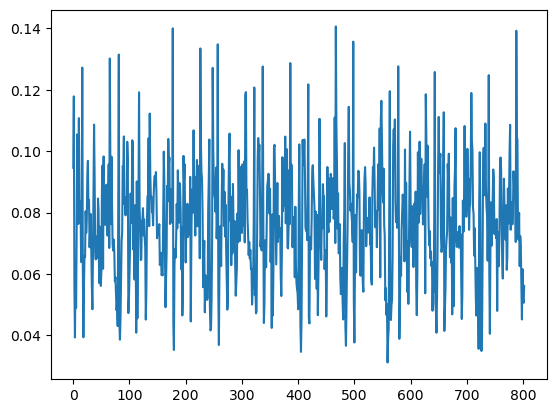

In [58]:
plt.plot(np.abs(trainer.model.get_weights()).mean(axis=(1,2)))

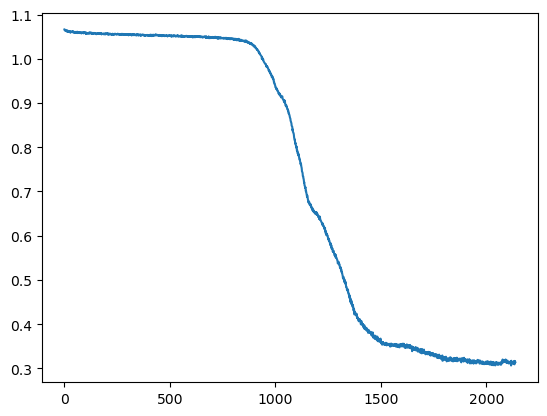

In [59]:
plt.plot(trainer.get_loss_history()[:])


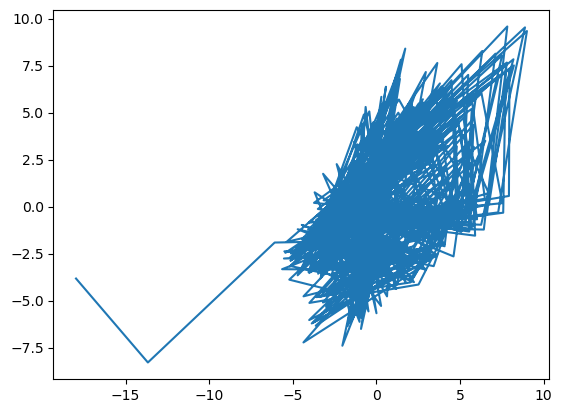

In [61]:
plt.plot(trainer.predict(X)[:,0,2],trainer.predict(X)[:,0,1])

In [62]:

unmixed = trainer.predict(X)

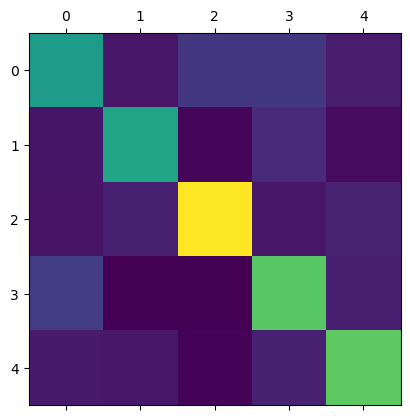

In [69]:
ccm = CCM.CCM(device="cpu")
plt.matshow(ccm.compute(np.transpose(unmixed,(1,0,2)), np.transpose(unmixed,(1,0,2)), 500, 150, 20, 10, 50).mean(axis=0))

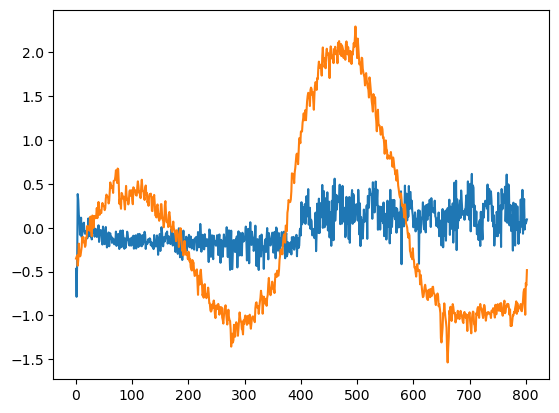

In [79]:
plt.plot(trainer.model.backward(torch.Tensor(np.transpose(unmixed,(0,2,1)),device="cpu").to("cuda")).cpu().detach().numpy()[:,4])
plt.plot(X[:,4])

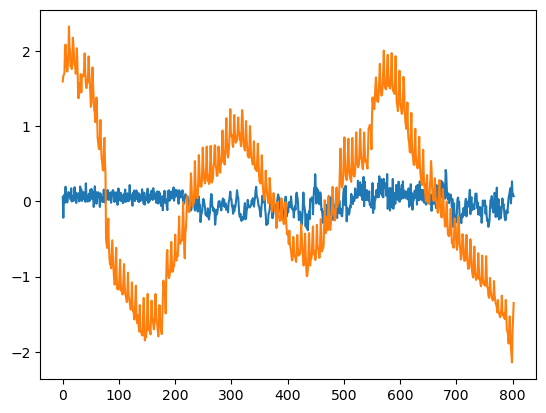

In [87]:
plt.plot(trainer.generate(X[:],20,20,1,"cpu")[1][:,5].cpu().detach().numpy())
plt.plot(X[:,5])

In [82]:
X_pred = np.array([trainer.generate(X[:],20,20,i,"cpu")[1].cpu().detach().numpy()[-300:] for i in range(1,75)])

NameError: name 'X_pred_aligned' is not defined

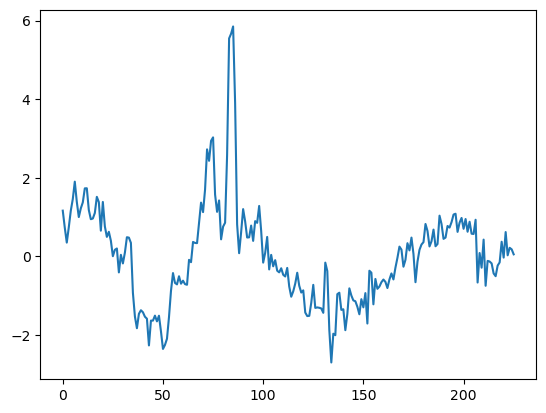

In [83]:
plt.plot(X[-(300-74):][:,17])
plt.plot(np.nanmean(X_pred_aligned[:,:-74,:],axis=0)[:,17])

In [290]:
X_pred_aligned = np.array([np.concatenate([X_pred[i,73-i:],np.full((73-i,X_pred.shape[2]),np.nan)]) for i in range(74)])

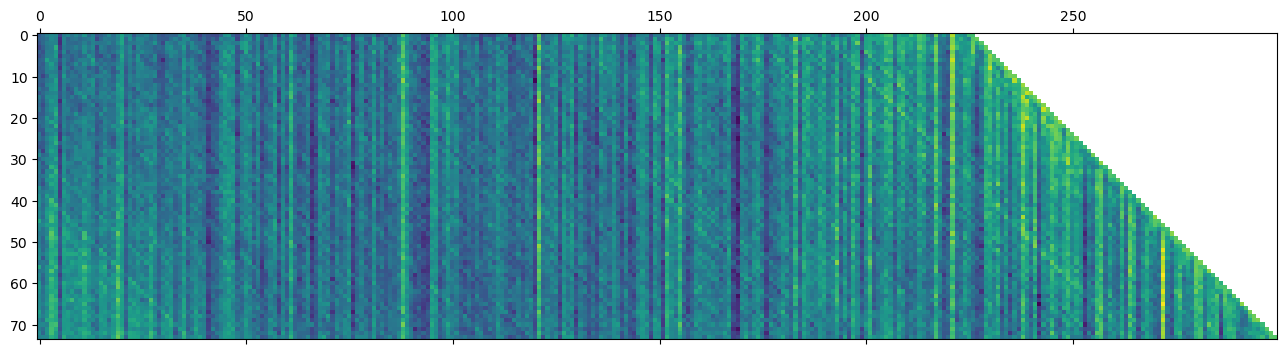

In [292]:
plt.matshow(X_pred_aligned[:,:,0])

In [293]:
X_ = np.nanmean(X_pred_aligned[:,-74:,:],axis=0)[:62]

(74, 100, 3212)

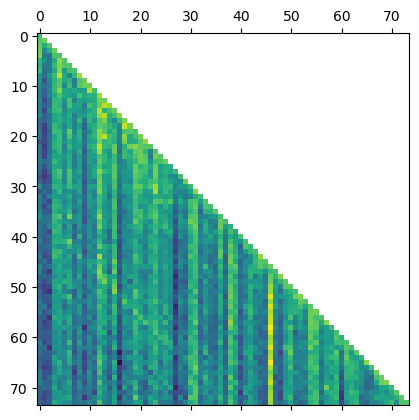

In [295]:
plt.matshow(X_pred_aligned[:,-74:,0])

In [296]:

X_ = pca.inverse_transform(X_[:,:803])

In [297]:
X_.shape

(62, 145035)

In [298]:
prediction = np.zeros((62,X_mean.shape[0]))
prediction[:,(X_mean != 0)] = X_[:]
prediction[:,(X_mean != 0)] = np.round(np.exp(((prediction[:,(X_mean != 0)]*X_std[(X_mean != 0)])+X_mean[(X_mean != 0)]))-1)

In [30]:
train_df = pd.read_csv("../src/manifold_learning/data/datasets/train_2.csv")
key_df = pd.read_csv("../src/manifold_learning/data/datasets/key_2.csv")

names = np.array([i[:-11] for i in key_df["Page"].to_numpy()])

sorted_indices = np.argsort(train_df["Page"].to_numpy())

# Create a sorted version of A
sorted_A = train_df["Page"].to_numpy()[sorted_indices]

# Use searchsorted to find the indices of B elements in the sorted A
order = sorted_indices[np.searchsorted(sorted_A, names[::62])]

(train_df["Page"][order].to_numpy() == names[::62]).sum()

145063

In [299]:
res = pd.read_csv("../src/manifold_learning/data/datasets/sample_submission_2.csv")
res["Visits"] = prediction[:,order].T.flatten().astype(int)

res.set_index("Id").to_csv("../src/manifold_learning/data/datasets/results_2.csv")

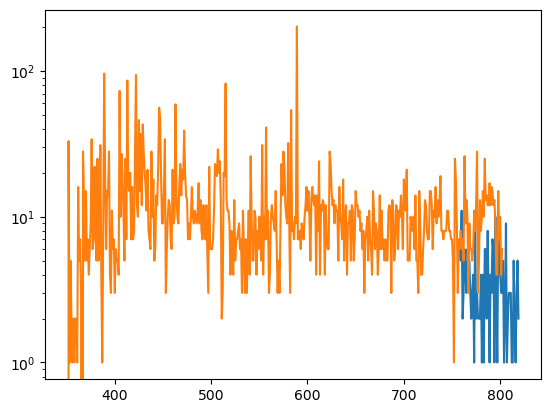

In [301]:
plt.plot(np.arange(X.shape[0],X.shape[0]+62),prediction[:,order[11713]])
plt.plot(train_df.iloc[order[11713]][1:].to_numpy())
#plt.xlim(600,920)
plt.yscale("log")

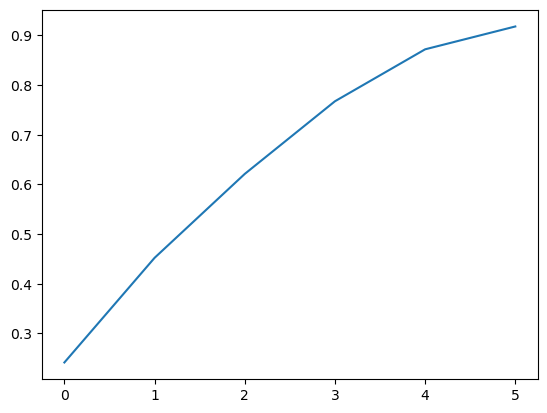

In [75]:

pca_ = PCA(6)
xxx = pca_.fit_transform(unmixed[:,1])
plt.plot(np.cumsum(pca_.explained_variance_ratio_))

ValueError: 'c' argument has 550 elements, which is inconsistent with 'x' and 'y' with size 803.

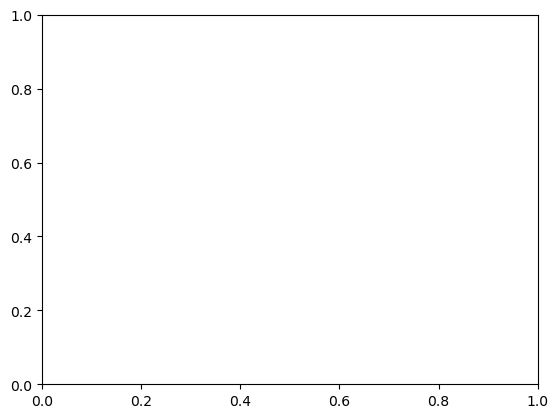

In [71]:
plt.scatter(xxx[:,0], xxx[:,1],c=np.arange(550))

In [76]:
import plotly.express as px
fig = px.line_3d(x=xxx[:,0], y=xxx[:,1],z=xxx[:,2],height=700)

fig.show()

CCM on MNIST dataset

In [ ]:

from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28)W.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
ccm.compute(x_train[None],y_train[None,:,None],5000,1000,1,20,0)

array([[[0.91143537]]], dtype=float32)

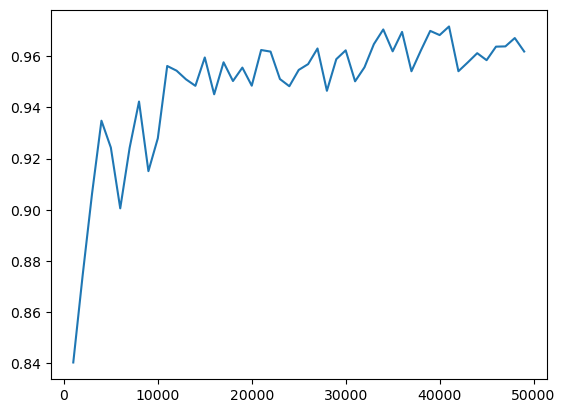

In [ ]:
plt.plot(np.arange(1000,50000,1000), [ccm.compute(x_train[None],y_train[None,:,None],n,1000,1,20,0)[0][0][0] for n in np.arange(1000,50000,1000)])

In [ ]:
t = np.linspace(0,200,20000)
r = np.linspace(0.1,5.2,2000)
resX1X2 = []
resX2X1 = []
for i in r:
    X1 = np.array([np.sin(t), np.cos(t)]).T[None]
    X2 = np.array([np.sin(i*t+1), np.cos(i*t+1)]).T[None]
    resX1X2 += [ ccm.compute(X1,X2,9000,1000,50,20,0).mean() ]
    resX2X1 += [ ccm.compute(X2,X1,9000,1000,50,20,0).mean() ]

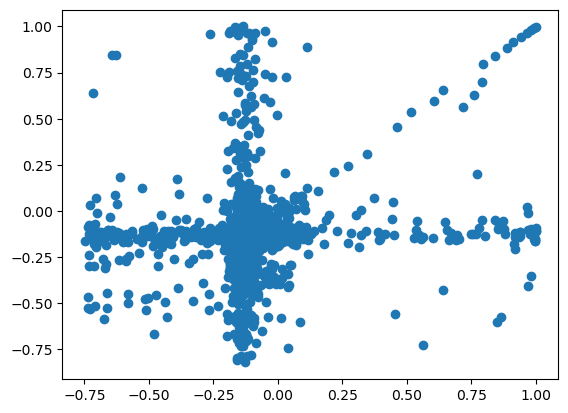

In [ ]:
plt.scatter(resX1X2, resX2X1)

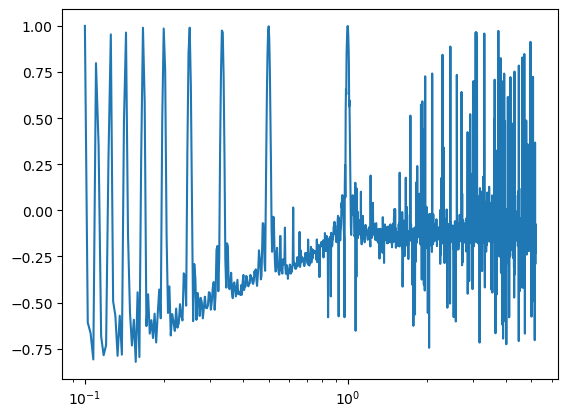

In [ ]:
plt.plot(r,resX2X1)
#plt.plot(r,resX1X2)
plt.xscale("log")

In [ ]:
X_emb = np.concatenate([np.array([np.sin(i*t), np.cos(i*t)]).T[None] for i in np.linspace(0.1,3.2,1000)])

In [ ]:
all_pairs_res = ccm.compute(X_emb,X_emb,1000,100,100,10,0).mean(axis=0)

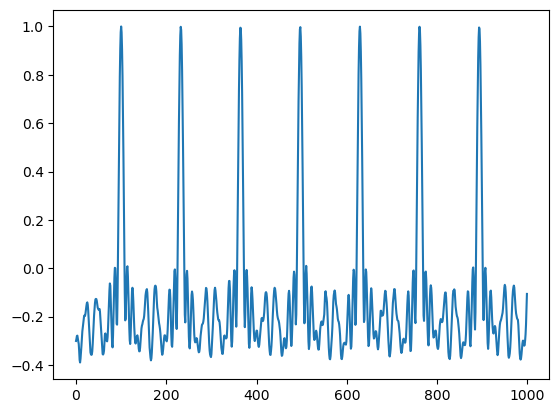

In [ ]:
plt.plot(all_pairs_res[:,100])

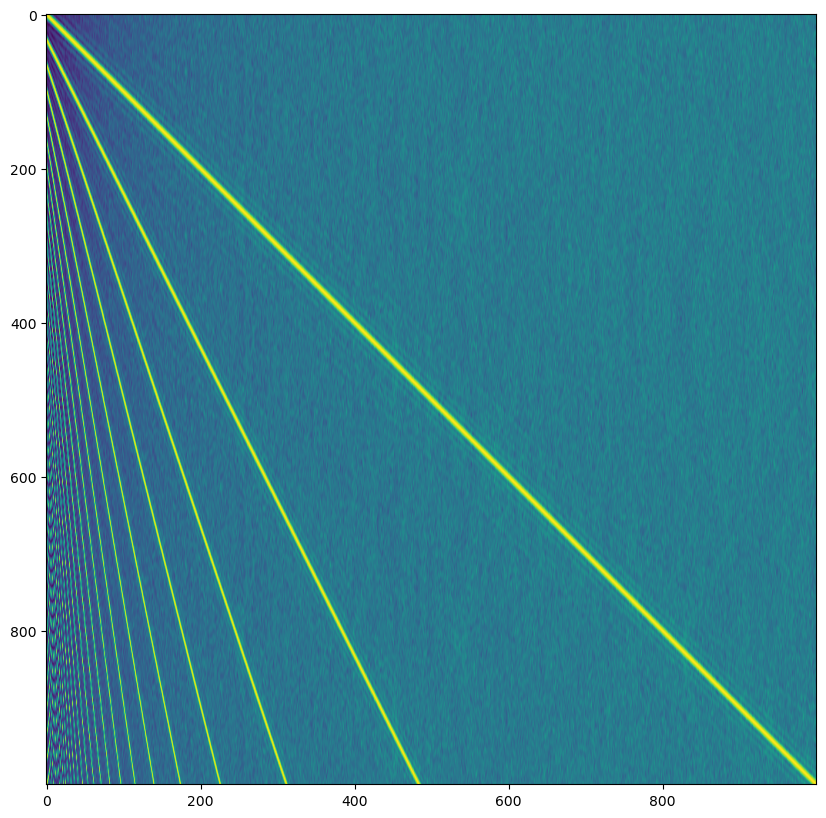

In [ ]:
plt.figure(figsize=(10,10),dpi=100)
plt.imshow(all_pairs_res)